
## EE 342:  Lab 2 - Elementary Music Synthesis

Instructor: Prof. Amy Orsborn

Teaching Assistant: Christopher Yin

**Overview**
The purpose of this lab is to familiarize you with constructing and processing discrete-time sound signals. You will learn how to synthesize music notes and play them in in Python $+$ SciPy environment. You will concatenate a series of music notes into a small music piece, add volume variation to the music piece, overlap the adjacent notes to further make the music smoother and more realistic.

Through this process, you will learn to perform the following sound synthesis tasks:
- Generating musical notes
- Improving the quality of the generated sound
- Overlapping notes

**Team Members**: Jordan White

In [24]:
!pip install sounddevice
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [25]:
# SimpleAudio constants.
DEFAULT_SAMPLE_RATE = 8000
DEFAULT_AMPLITUDE = 1

# Musical note frequencies.
A = 220.0
B = A * 2 ** (2 / 12)
C = A * 2 ** (3 / 12)
E = A * 2 ** (7 / 12)

## Task 1: Generating Musical Notes

In [26]:
def play(data, sample_rate=DEFAULT_SAMPLE_RATE):
    """Plays audio data.

    Args:
        data: The audio data to be played (as a NumPy array).
        sample_rate: The sample rate.
    """
    sd.play((data*32767).astype('int16'),sample_rate)

In [36]:
# defining note function 
def note(frequency, duration, amplitude=DEFAULT_AMPLITUDE, sample_rate=DEFAULT_SAMPLE_RATE):
    """Generates samples of a musical note.

    Samples are generated according to following equation:

        y(t) = A sin(wt)

    Args:
        frequency: The frequency of the note in Hz.
        duration: The length of the note in seconds.
        amplitude: The amplitude of the note.
        sample_rate: The sample rate in Hz.

    Returns:
        An array of samples representing the note.
    """
    sample_count = int(duration * sample_rate)
    note_sig = np.zeros(sample_count)
    t = np.linspace(0, duration, sample_count)
    
    for i in range(sample_count):
        note_sig[i] = amplitude * np.sin(t[i]*frequency)
        
    return note_sig

In [37]:
# Use your function to generate the musical score for the Scarborough Fair.
sample_per = 4000 # In this Lab, use a duration of 4,000 samples for 1 count.

whole_t = 4 * sample_per / DEFAULT_SAMPLE_RATE
half_t = whole_t / 2
quarter_t = half_t / 2

A_freq = 2 * np.pi * 220
B_freq = 2 * np.pi * 220 * (2 ** (2/12))
C_freq = 2 * np.pi * 220 * (2 ** (3/12))
D_freq = 2 * np.pi * 220 * (2 ** (5/12))
E_freq = 2 * np.pi * 220 * (2 ** (7/12))
F_freq = 2 * np.pi * 220 * (2 ** (8/12))
G_freq = 2 * np.pi * 220 * (2 ** (10/12))
A_freq_2 = 2 * 220

score = [[A_freq, half_t], [A_freq, quarter_t], [E_freq, quarter_t], 
         [E_freq, quarter_t], [E_freq, quarter_t], [B_freq, quarter_t], 
         [C_freq, quarter_t], [B_freq, quarter_t], [A_freq, whole_t]]

note_list = [note(freq, dur) for [freq, dur] in score]
rest_sig = np.zeros(500).tolist()

# making the song with pauses after each note
song = np.append(np.array([]), note_list[0])

for n in range (1, len(note_list)):
    song = np.append(song, rest_sig)
    song = np.append(song, note_list[n])

# Play the audio sample
play(song)

## Task 2: Volume Variations

In [38]:
### This code is provided to you. ###

def display_envelope(signal,duration=-1,sample_rate=DEFAULT_SAMPLE_RATE):

    """
    Plots the envelope of a duration of the generated audio. 

    Args:
        signal: The audio signal to be displayed (as a NumPy array).
        duration: The length of hte signal to be displayed. -1 to display entire signal.
        sample_rate: The sample rate.
    """
    
    from scipy.signal import hilbert
    
    if duration < 0:
        duration = len(signal)/sample_rate
    
    n = int(duration*sample_rate)
    
    analytic_signal = hilbert(signal[0:n])
    amplitude_envelope = np.abs(analytic_signal)
        
    t = np.linspace(0,duration,len(amplitude_envelope))
    
    plt.figure()    
    plt.plot(t,amplitude_envelope)
    plt.show()

In [62]:
# Volume Variation Function Attack, Decay, Sustain and Release (ADSR)
def adsr(note):
    """Generates an ADSR envelope and applies it to a note.

        A: Linear increase to 60% amplitude over 20% length.
        D: Linear decrease to 50% amplitude over 4% length.
        S: Constant 50% amplitude over 40% length.
        R: Linear decrease to 0% amplitude over 36% length.

    Args:
        note: The note to be modified.

    Returns:
        A note that has been scaled by the ADSR envelope.
    """
    n = len(note)
    
    a_t = int(.2*n)
    d_t  = int(.05*n)
    s_t  = int(.6*n)
    r_t  = int(.15*n)
    
    a = np.linspace(0, .7, a_t)
    d = np.linspace(-1/d_t + .7, .5, d_t)
    s = .5 * np.ones(s_t)
    r = np.linspace(.5, 0, r_t)
    
    adsr_comb = np.concatenate((a,d,s,r))
    filtered_note = note*adsr_comb
    
    return filtered_note

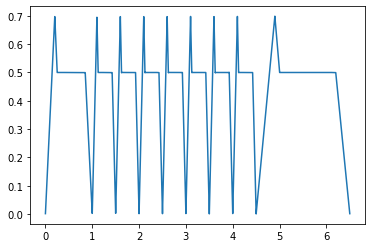

In [63]:
# Use your function Apply an ADSR envelope to each note.
note_list2 = note_list.copy()
note_list2f = note_list2.copy()

for n in range(len(note_list2)):
    note_list2f[n] = adsr(note_list2[n])
    
filtered = np.concatenate(note_list2f)

# Play the audio sample
play(filtered)

# Display the envelope
display_envelope(filtered)

**Discussion Question:** Instead of enveloping with the ADSR function, how would you envelope with a decaying exponential?

We would get each note in the song and apply a decaying exponential function to them, so instead of with the ADSR where we applied multiple linear transformation to a note, we would only need to multiply the sinusoid by a decaying exponential

**Optional:** Implement a decaying exponential envelope.

## Task 3: Overlapping Notes

In [64]:
def overlap(notes, offset):
    """Joins notes together with overlap between consecutive notes.

    Args:
        notes: An array of notes to be joined.
        offset: The amount of allowable overlap between consecutive notes.

    Returns:
        A score made from the input notes.
    """
    # Enter code here
    music = notes[0]
    for n in range(1, len(notes)):
        cur = notes[n]
        adjacent = cur[offset:]
        for i in range(offset):
            music[len(music) - offset + i] += min(cur[i], 1)
        music = np.append(music, adjacent)
    return music

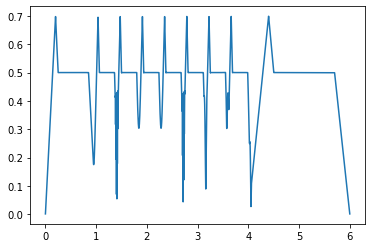

In [65]:
# Smooth the sound by overlapping the notes.
note_copy_again = note_list2f.copy()

overlapped = overlap(note_copy_again, 500)

# Play the audio sample
play(overlapped)

# Display the envelope
display_envelope(overlapped)